In [23]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines_qulacs import *     #for Qulacs Simulator backend
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from typing import Union
from qumcmc.trajectory_processing import *
import seaborn as sns

            MODEL : my_model
Non-zero Interactions (J) : 55 / 55
Non-zero Bias (h) : 11 / 11
---------------------------------------------
Average Interaction Strength <|J|> :  0.6211900826446279
Average Bias Strength <|h|>:  0.30454545454545456
alpha :  0.5112239270751668
---------------------------------------------


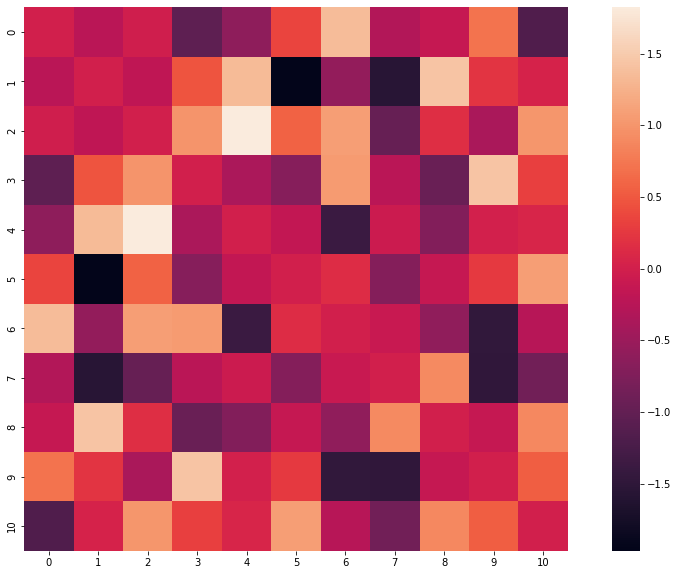

In [24]:
# define the model
np.random.seed(206147358) ##l lucky-seed: 610358
n_spins = 11

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

model.model_summary()
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
esm = Exact_Sampling(model, beta)
# esm.run_exact_sampling(beta)

     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 6
Entropy : 1.7853625862041032
---------------------------------------------


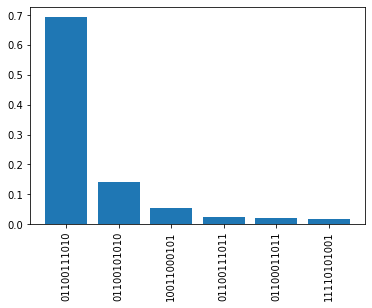

In [25]:
esm.sampling_summary()

In [4]:
# steps = 10000
# cl_chain =classical_mcmc(
#     n_hops=steps,
#     model=model,
#     temperature=1/beta,
# )
# steps = 1000
# qamcmc_chain =quantum_enhanced_mcmc(
#     n_hops=steps,
#     model=model,
#     temperature=1/beta,
#     verbose = False
# )

In [5]:
# class IsingEnergyFunction:
#     """ A class to build the Ising Energy Function from data  
#     """

#     def __init__(self, J: np.array, h: np.array, name:str = None) -> None:
#         """
#             ARGS:
#             ----
#             J: weight-matrix of the interactions between the spins 
#             h: local field to the spins 

#         """
#         self.J = J
#         self.h = h
#         # self.beta = beta
#         self.num_spins = len(h)
#         # self.exact_sampling_status = False
#         self.alpha = np.sqrt(self.num_spins) / np.sqrt( sum([J[i][j]**2 for i in range(self.num_spins) for j in range(i)]) + sum([h[j]**2 for j in range(self.num_spins)])  )

#         if name == None: 
#             self.name = 'JK_random'
#         else : self.name = name 
    
#     @property
#     def get_J(self):
#         return self.J
    
#     @property
#     def get_h(self):
#         return self.h

#     # @property
#     def model_summary(self, plot= True) :
        
#         print("=============================================")
#         print("            MODEL : "+str(self.name) )
#         print("=============================================")
        
        
#         print("Non-zero Interactions (J) : "+ str( int(np.count_nonzero(self.J) /2)) + ' / '+str( int( 0.5 * self.num_spins * (self.num_spins - 1))) )
#         print("Non-zero Bias (h) : "+ str( int(np.count_nonzero(self.h) )) + ' / ' + str( self.num_spins ) )
#         print("---------------------------------------------")

#         print("Average Interaction Strength <|J|> : ", np.mean(np.abs(self.J)))
#         print("Average Bias Strength <|h|>: ", np.mean(np.abs(self.h)))
#         print("alpha : ", self.alpha )
    
#         print("---------------------------------------------")


#         # sns.set()
#         if plot:
#             plt.figure(figsize=(16,10))
#             sns.heatmap(self.J, square= True, annot= False, cbar= True)
            

#     def get_energy(self, state: Union[str, np.array]) -> float:
#         """ Returns the energy of a given state

#             ARGS:
#             ----
#             state : configuration of spins for which the energy is requrieed to be calculated.
#                     NOTE:  if input is an numpy array then it should only consist of bipolar values -> {+1, -1}

#         """

#         if isinstance(state, str):
#             state = np.array([-1 if elem == "0" else 1 for elem in state])
#             # state = np.array( [int(list(state)[i]) for i in range(len(state))])
#             energy = 0.5 * np.dot(state.transpose(), self.J.dot(state)) + np.dot(
#                 self.h.transpose(), state
#             )
#             return energy
#         else:
#             return 0.5 * np.dot(state.transpose(), self.J.dot(state)) + np.dot(
#                 self.h.transpose(), state
#             )


#     def get_boltzmann_factor(
#         self, state: Union[str, np.array], beta: float = 1.0
#     ) -> float:

#         """ Get un-normalised boltzmann probability of a given state 

#             ARGS:
#             ----
#             state : configuration of spins for which probability is to be calculated 
#             beta : inverse temperature (1/T) at which the probability is to be calculated.
        
#         """
#         return np.exp(-1 * beta * self.get_energy(state))
    
#     from typing import List
#     def _update_J(self, new_param:float, index: Union[tuple, List]):

#         assert len(index) == 2
#         self.J[index[0], index[1]] = new_param
#         self.J[index[1], index[0]] = new_param
    
#     def _update_h(self, new_param: float, index: int):

#         self.h[index] = new_param

# class DiscreteProbabilityDistribution(dict):
#     """ A class for handling discrete probability distributions """

#     def __init__(self, distribution:dict) -> None :

#         super().__init__(distribution) 
    
#     def _normalise(self, print_normalisation:bool= False):
#         """ Normalise the given disribution 
#             NOTE: works inplace 
#         """
        
#         r_sum = np.sum(list(self.values()))
#         if print_normalisation : print('Normalisation : ', r_sum)
#         for k in list(self.keys()) :
#             self[k] = self[k] / r_sum

#     def value_sorted_dict(self, reverse=False):
#         """ Sort the dictionary in ascending or descending(if reverse=True) order of values. """
#         sorted_dict = {
#             k: v
#             for k, v in sorted(self.items(), key=lambda item: item[1], reverse=reverse)
#         }
#         return sorted_dict

#     def index_sorted_dict(self, reverse= False):
#         """ Sort the dictionary in ascending or descending(if reverse=True) order of index. """
#         sorted_dict = {
#             k: v
#             for k, v in sorted(self.items(), key=lambda item: item[0], reverse=reverse)
#         }
#         return sorted_dict
   
#     def get_truncated_distribution(self, epsilon:float = 0.00001, inplace:bool = False):
        
#         return_dict = {}
#         index_probable_elements = [ indx for indx, b in enumerate( np.array(list(self.values())) > epsilon ) if b ]
#         states = list(self.keys())
#         probs = list(self.values())

#         for indx in index_probable_elements:
#             return_dict[states[indx]] = probs[indx]
        
#         if not inplace:
#             return DiscreteProbabilityDistribution(return_dict)
#         else :
#             self.__init__(return_dict)
            
#     def expectation(self, dict_observable_val_at_states: dict):
#         """
#         new version:
#         Returns average of any observable of interest

#         Args:
#         self= {state: probability}
#         dict_observable_val_at_states={state (same as that of self): observable's value at that state}

#         Returns:
#         avg
#         """
#         ##TODO: A faster implementation is possible by using numpy 
#         len_dict = len(self)
#         temp_list = [
#             self[j] * dict_observable_val_at_states[j]
#             for j in (list(self.keys()))
#         ]
#         avg = np.sum(
#             temp_list
#         )  # earlier I had np.mean here , which is wrong (obviously! duh!)
#         return avg

#     def get_entropy(self):
#         tmp = sorted(np.array(list(self.values())), reverse= True)
#         entropy = 0
#         for val in tmp :
#             if val > 0.00001 :
#                 entropy += -1 * val * np.log2(val)
#             else: 
#                 return entropy
    
#     def get_observable_expectation(self, observable) -> float:
#         """ Return expectation value of a classical observables

#             ARGS :
#             ----
#             observable: Must be a function of the spin configuration which takes an 'np.array' / 'str' of binary elements as input argument and returns a 'float'
#             beta: inverse temperature

#         """
#         # all_configs = np.array(list(itertools.product([1, 0], repeat=self.num_spins)))
#         # all_configs = [f"{k:0{self.num_spins}b}" for k in range(0, 2 ** (self.num_spins))]
        

#         return np.sum(
#             [
#                 self[config]
#                 * observable(config)

#                 for config in self.keys()
#             ]
#         )



#### HELPER FUNCTIONS

In [26]:
int_to_binary = lambda state_obtained, n_spins : f"{state_obtained:0{n_spins}b}"
binary_to_bipolar = lambda string : 2.0 * float(string) - 1.0

def get_observable_expectation(observable: callable, mcmc_chain: MCMCChain, skip_init:int= 100) :

    sample_observable = []
    for s in mcmc_chain.accepted_states :

        sample_observable.append(observable(s) )
    
    sample_observable = np.array(sample_observable)
        
    return sample_observable.mean(dtype= float)#, sample_observable.var(dtype= float)


def correlation_spins(state: str, indices : Union[tuple, List] ):

    assert len(indices) <= len(state)
    
    
    prod = 1.0
    for _ in indices :
        prod *= binary_to_bipolar(state[_])

    return prod

def cd_J(index, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert len(index) == 2
    observable = lambda s: correlation_spins(s, [index[0], index[1]])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

def cd_h(index:int, data_distribution:DiscreteProbabilityDistribution, mcmc_chain: MCMCChain):

    assert isinstance(index, int)
    observable = lambda s: correlation_spins(s, [index])
    r = data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

    return r

#### Class for Training

In [32]:
# @dataclass
class cd_training():

    def __init__(self, model: IsingEnergyFunction, beta:float ,data_dist: DiscreteProbabilityDistribution) -> None:
        self.model = model
        self.model_beta = beta
        self.data_distribution = data_dist
        self.training_history = {}
        pass

    def cd_J(self, index, mcmc_chain: MCMCChain):

        assert len(index) == 2
        observable = lambda s: correlation_spins(s, [index[0], index[1]])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    def cd_h(self, index:int, mcmc_chain: MCMCChain):

        assert isinstance(index, int)
        observable = lambda s: correlation_spins(s, [index])
        r = self.data_distribution.get_observable_expectation(observable) - get_observable_expectation(observable, mcmc_chain, skip_init= 100)

        return r

    # @setattr
    # def data_distribution()
    
    def _train_on_mcmc_chain(self, lr:float= 0.01, method = 'quantum-enhanced', iterations: int = 100, mcmc_steps:int =1000 ):

        if method == 'quantum-enhanced' :
            self.mcmc_chain = quantum_enhanced_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        elif method == 'classical-uniform' : 
            self.mcmc_chain = classical_mcmc(
            n_hops=mcmc_steps,
            model=self.model,
            temperature=1/self.model_beta,
            verbose= False
            )
        
        ## random update strategy ##
        for _ in range(iterations):
            
            ## update J ##
            index = [np.random.randint(0, self.model.num_spins), np.random.randint(0, self.model.num_spins)]

            updated_param_j = model.J[index[0], index[1]] + lr * self.cd_J(index, self.mcmc_chain) 
            
            self.model._update_J(updated_param_j, index)

            ## update h ##
            index = np.random.randint(0, self.model.num_spins)

            updated_param_h = model.h[index] + lr * self.cd_h(index, self.mcmc_chain) 
            
            self.model._update_h(updated_param_h, index)

            

    def train(self, lr:float= 0.01, method = 'quantum-enhanced', epochs:int = 10, iterations: int = 100, mcmc_steps:int = 500, show_kldiv:bool = True ):

        ## random update strategy ##
        kl_div = []
        iterator = tqdm(range(epochs), desc= 'training epochs'  )
        iterator.set_postfix({'method': method})
        for epoch in iterator:

            self._train_on_mcmc_chain(lr= lr , method = method, iterations= iterations, mcmc_steps= mcmc_steps )

            if show_kldiv:

                
                kl_div.append(kl_divergence(  self.mcmc_chain.get_accepted_dict(normalize= True), self.data_distribution ))
                iterator.set_postfix( { 'method ': method, 'kl div ' : kl_div[-1] })
        
        if show_kldiv : self.training_history['kl_div']= kl_div


#### TRIALS

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 11
Entropy : 3.384423176634566
---------------------------------------------


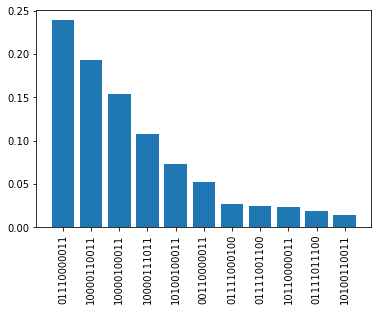

In [33]:
## INITIALISE ANOTHER RANDOM MODEL ##

np.random.seed(20648)# should always be in the same cell!  
n_spins = 11

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -3, high= 3, size= shape_of_J )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.4 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
beta_train = 1.001

param_model = IsingEnergyFunction(J, h, name= 'param_model')
param_model_esm = Exact_Sampling(param_model, beta= beta_train)

param_model_esm.sampling_summary()

     MODEL : my_model |  beta : 1.100209
Num Most Probable States : 6
Entropy : 1.7853625862041032
---------------------------------------------


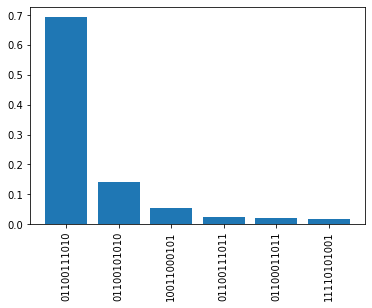

In [34]:
## COMPARE WITH THE DATA-DISTRIBUTION ##
esm.sampling_summary()

#### TRAINING

In [36]:
training_quantum = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_quantum.train(lr = 0.01 ,method = 'quantum-enhanced' , epochs= 6, iterations= 100, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 6/6 [02:00<00:00, 20.01s/it, method =quantum-enhanced, kl div =0.414]


In [35]:
training_cl = cd_training(param_model, beta_train, esm.boltzmann_pd)
training_cl.train(lr = 0.06 ,method = 'classical-uniform' , epochs= 6, iterations= 100, mcmc_steps= 1000 , show_kldiv= True)

training epochs: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s, method =classical-uniform, kl div =4.55]


##### Compare reconstructed model

In [37]:
classical_reconstructed_model_esm = Exact_Sampling(training_cl.model, beta= beta_train)
quantum_reconstructed_model_esm = Exact_Sampling(training_quantum.model, beta= beta_train)

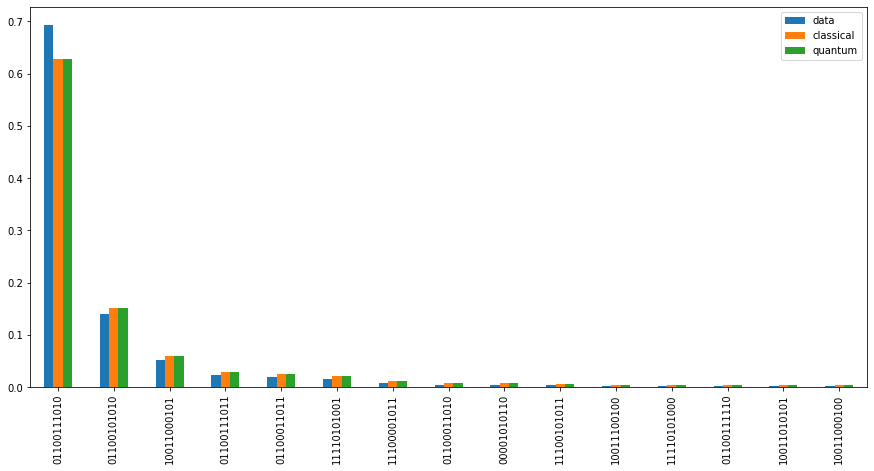

In [38]:
plot_multiple_bargraphs([esm.boltzmann_pd, classical_reconstructed_model_esm.boltzmann_pd, quantum_reconstructed_model_esm.boltzmann_pd], ['data','classical', 'quantum'], list_normalise=[False,False,False], plot_first_few= 15)

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 7
Entropy : 2.1669852913191576
---------------------------------------------


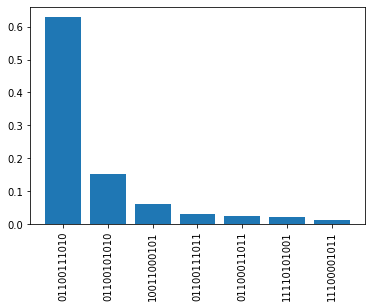

In [39]:
classical_reconstructed_model_esm.sampling_summary()

     MODEL : param_model |  beta : 1.001
Num Most Probable States : 7
Entropy : 2.1669852913191576
---------------------------------------------


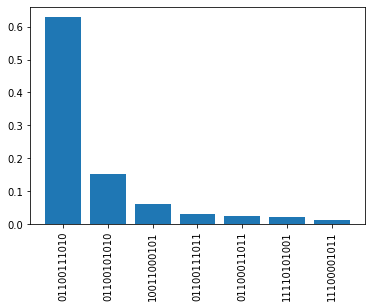

In [40]:
quantum_reconstructed_model_esm.sampling_summary()

In [41]:
training_quantum.mcmc_chain.get_accepted_dict(norma)

MCMCChain()